<a href="https://colab.research.google.com/github/BrindhaGanesh/ML_Projects/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
file_path = r"/content/Scraped_Car_Review_maserati.csv"
df = pd.read_csv(file_path)
df.head()


,Unnamed: 0,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating
0,0,on 01/01/05 19:28 PM (PST),Jeff,2004 Maserati Spyder Convertible Cambiocorsa 2...,Maserati Thrill Ride,I bought my Maserati Spyder Cambiocorsa \rin ...,4.875
1,1,on 12/05/04 06:07 AM (PST),Francie,2004 Maserati Spyder Convertible Cambiocorsa 2...,My second Spyder,I got the very first Maserati Spyder delivere...,4.750
2,2,on 12/04/04 15:28 PM (PST),West8,2004 Maserati Spyder Convertible GT 2dr Conver...,Fast & Fun,After owning several comparable cars in the p...,4.375
3,3,on 10/28/04 00:00 AM (PDT),KLAMIA2001,2004 Maserati Spyder Convertible Cambiocorsa 2...,ITALIANS RULE,"THIS IS MY THIRD MASERATI, A 2002, 2003 \r& A...",5.000
4,4,on 09/22/04 00:00 AM (PDT),d blair,2004 Maserati Spyder Convertible Cambiocorsa 2...,Midlife Crisis?? I don't think so!,Ok so I am a 55 year old man who has,NaN


In [ ]:
print(df.isnull().sum())

Unnamed: 0        0
Review_Date      52
Author_Name      63
Vehicle_Title    63
Review_Title     63
Review           63
Rating           74
dtype: int64


In [ ]:
df_cleaned = df.drop(columns=['Unnamed: 0', 'Review_Date', 'Author_Name', 'Vehicle_Title', 'Review_Title'])
df_cleaned.head()
print(df_cleaned.shape)

(302, 2)


In [ ]:

# %%
df_cleaned = df_cleaned.dropna(subset=['Review', 'Rating'])
print(df_cleaned.shape)


(228, 2)


In [ ]:
# %%
def rating_to_sentiment(rating):
    if rating >= 4.0:
        return 'positive'
    elif rating >= 3.0:
        return 'neutral'
    else:
        return 'negative'

df_cleaned['sentiment'] = df_cleaned['Rating'].apply(rating_to_sentiment)

In [ ]:

# %%
print(df_cleaned.head())

                                               Review  Rating sentiment
0    I bought my Maserati Spyder Cambiocorsa \rin ...   4.875  positive
1    I got the very first Maserati Spyder delivere...   4.750  positive
2    After owning several comparable cars in the p...   4.375  positive
3    THIS IS MY THIRD MASERATI, A 2002, 2003 \r& A...   5.000  positive
20   This car is a Ferrari in a Maserati \rbody. T...   4.500  positive


<ipython-input-34-06ae31b716f4>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df_cleaned, palette='Set2')


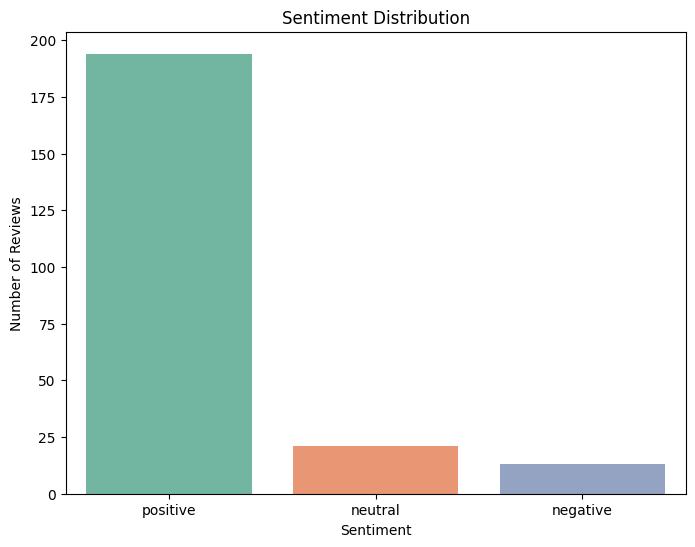

In [ ]:

# %%
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_cleaned, palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
pip install torch scikit-learn


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract the sentiment labels
sentiments = df_cleaned['sentiment'].values

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Ensures the weights are inversely proportional to class frequencies
    classes=np.unique(sentiments),  # Unique classes in the sentiment labels
    y=sentiments  # Labels
)

# Create a dictionary mapping each class to its corresponding weight
class_weights_dict = {label: weight for label, weight in zip(np.unique(sentiments), class_weights)}

print(f"Class weights: {class_weights_dict}")


Class weights: {'negative': 5.846153846153846, 'neutral': 3.619047619047619, 'positive': 0.3917525773195876}


In [ ]:
# Create a mapping from sentiment labels to numerical values
sentiment_to_num = {'negative': 0, 'neutral': 1, 'positive': 2}

# Apply the mapping to convert sentiment to numerical labels
df_cleaned['label'] = df_cleaned['sentiment'].map(sentiment_to_num)

print(df_cleaned[['sentiment', 'label']].head())

   sentiment  label
0   positive      2
1   positive      2
2   positive      2
3   positive      2
20  positive      2


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)

    # Compute precision, recall, and F1 score for each class (weighted average)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

# Define your Dataset class if not done already
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = self.reviews[index]
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and model (e.g., DistilBERT)
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Train-Test Split
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, stratify=df_cleaned['label'], random_state=42)

# Create Dataset instances
train_dataset = ReviewDataset(train_df['Review'].values, train_df['label'].values, tokenizer, max_len=128)
test_dataset = ReviewDataset(test_df['Review'].values, test_df['label'].values, tokenizer, max_len=128)

# Compute class weights for PyTorch
class_weights = torch.tensor([class_weights_dict['negative'], class_weights_dict['neutral'], class_weights_dict['positive']], dtype=torch.float)

# Define a custom Trainer class where we specify the class weights for the loss function
from transformers import Trainer
from torch.nn import CrossEntropyLoss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
)

# Initialize the Trainer with custom metrics
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add this line to compute metrics
)


# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.089567,0.086957,0.015031,0.086957,0.025528
2,No log,1.081840,0.826087,0.792029,0.826087,0.807485
3,No log,1.009156,0.826087,0.790373,0.826087,0.803543
4,No log,0.924072,0.804348,0.820595,0.804348,0.812096
5,No log,1.429723,0.847826,0.836198,0.847826,0.820573
6,No log,1.597466,0.847826,0.836198,0.847826,0.820573
7,No log,1.722075,0.869565,0.875776,0.869565,0.852013
8,No log,1.933368,0.847826,0.810559,0.847826,0.824477
9,0.530000,2.038828,0.847826,0.810559,0.847826,0.824477
10,0.530000,2.039575,0.847826,0.810559,0.847826,0.824477


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=120, training_loss=0.4484071056048075, metrics={'train_runtime': 10.0865, 'train_samples_per_second': 180.44, 'train_steps_per_second': 11.897, 'total_flos': 60273741265920.0, 'train_loss': 0.4484071056048075, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 2.0395750999450684,
 'eval_accuracy': 0.8478260869565217,
 'eval_precision': 0.8105590062111802,
 'eval_recall': 0.8478260869565217,
 'eval_f1': 0.8244766505636071,
 'eval_runtime': 0.0927,
 'eval_samples_per_second': 496.421,
 'eval_steps_per_second': 32.375,
 'epoch': 10.0}

In [ ]:
# %%
# Extract features (reviews) and target (sentiments)
X = df_cleaned['Review']
y = df_cleaned['sentiment']


In [ ]:
# %%
from imblearn.over_sampling import RandomOverSampler
# Instantiate the oversampler
ros = RandomOverSampler(random_state=42)

# Resample the dataset (Note: X needs to be reshaped for resampling)
X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)

# Convert the resampled dataset back into a DataFrame
df_resampled = pd.DataFrame({'Review': X_resampled.flatten(), 'sentiment': y_resampled})

# Check the new sentiment distribution
print(df_resampled['sentiment'].value_counts())

sentiment
positive    194
neutral     194
negative    194
Name: count, dtype: int64


In [ ]:

# %%
df_resampled.head()

,Review,sentiment
0,I bought my Maserati Spyder Cambiocorsa \rin ...,positive
1,I got the very first Maserati Spyder delivere...,positive
2,After owning several comparable cars in the p...,positive
3,"THIS IS MY THIRD MASERATI, A 2002, 2003 \r& A...",positive
4,This car is a Ferrari in a Maserati \rbody. T...,positive


<ipython-input-11-aabaa4661ed0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df_resampled, palette='Set2')


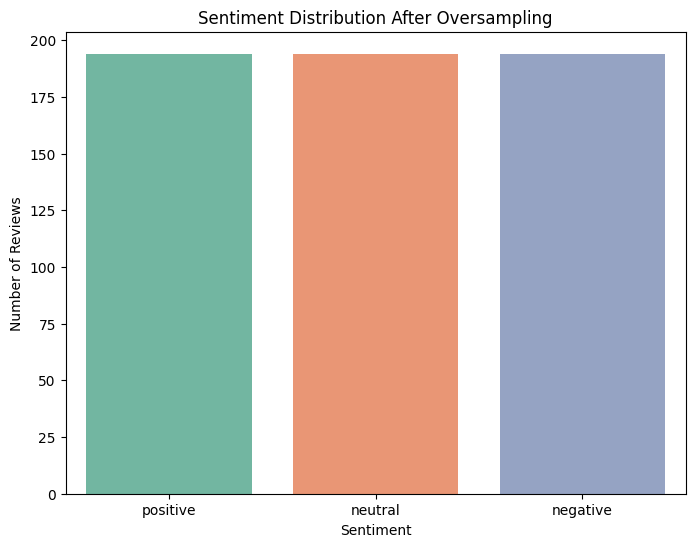

In [ ]:
# %%
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_resampled, palette='Set2')
plt.title('Sentiment Distribution After Oversampling')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
# %%
import re

# Define a function to clean review text
def clean_review_text(text):
    # Remove unwanted characters (e.g., "\r", "\n")
    text = re.sub(r'[\r\n]', ' ', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower().strip()
    return text

# Apply the function to clean the Review column
df_cleaned['cleaned_review'] = df_cleaned['Review'].apply(clean_review_text)

# Verify cleaned text
print(df_cleaned[['Review', 'cleaned_review']].head())

                                               Review  \
0    I bought my Maserati Spyder Cambiocorsa \rin ...   
1    I got the very first Maserati Spyder delivere...   
2    After owning several comparable cars in the p...   
3    THIS IS MY THIRD MASERATI, A 2002, 2003 \r& A...   
20   This car is a Ferrari in a Maserati \rbody. T...   

                                       cleaned_review  
0   i bought my maserati spyder cambiocorsa  in ma...  
1   i got the very first maserati spyder delivered...  
2   after owning several comparable cars in the pa...  
3   this is my third maserati a     a  nobody make...  
20  this car is a ferrari in a maserati  body the ...  


In [ ]:
# %%
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['cleaned_review'], df_cleaned['sentiment'],
                                                    test_size=0.2, random_state=42, stratify=df_cleaned['sentiment'])

# Check the shape of the split data
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 182
Test set size: 46


In [ ]:

# %%
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the training data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)

# Tokenize the testing data
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# %%
label_mapping = {'positive': 0, 'neutral': 1, 'negative': 2}

# Convert labels to numerical format
y_train = y_train.map(label_mapping).values
y_test = y_test.map(label_mapping).values

In [ ]:

# %%
import torch

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset objects for training and testing
train_dataset = ReviewDataset(train_encodings, y_train)
test_dataset = ReviewDataset(test_encodings, y_test)


In [ ]:


# %%
from transformers import AutoModelForSequenceClassification

# Load pre-trained DistilBERT model
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)  # 3 labels: positive, neutral, negative

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [ ]:


# %%
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # Output directory for model checkpoints
    evaluation_strategy="epoch",     # Evaluate at the end of every epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

# Define the Trainer class
trainer = Trainer(
    model=model,                         # The pre-trained model
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # The training dataset
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics

)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.237400,0.378871,0.891304,0.863406,0.837964,0.891304
2,0.189600,0.355915,0.891304,0.863406,0.837964,0.891304
3,0.110800,0.374407,0.891304,0.856158,0.826930,0.891304
4,0.134800,0.397981,0.891304,0.856158,0.826930,0.891304
5,0.106400,0.380362,0.891304,0.856158,0.826930,0.891304
6,0.105600,0.410301,0.891304,0.856158,0.826930,0.891304
7,0.066200,0.390771,0.913043,0.881643,0.852484,0.913043
8,0.085400,0.564633,0.891304,0.854723,0.838439,0.891304
9,0.072600,0.424227,0.891304,0.856158,0.826930,0.891304
10,0.069500,0.404691,0.891304,0.856158,0.826930,0.891304


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

TrainOutput(global_step=120, training_loss=0.11072690437237422, metrics={'train_runtime': 8.5125, 'train_samples_per_second': 213.803, 'train_steps_per_second': 14.097, 'total_flos': 60273741265920.0, 'train_loss': 0.11072690437237422, 'epoch': 10.0})

In [ ]:
trainer.evaluate()



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.40469127893447876,
 'eval_accuracy': 0.8913043478260869,
 'eval_f1': 0.8561581578548704,
 'eval_precision': 0.8269295584765757,
 'eval_recall': 0.8913043478260869,
 'eval_runtime': 0.0679,
 'eval_samples_per_second': 677.922,
 'eval_steps_per_second': 44.212,
 'epoch': 10.0}

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


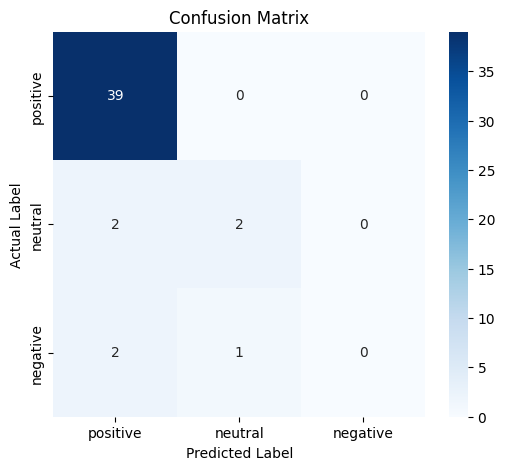

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

# Confusion matrix
cm = confusion_matrix(y_test, preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
model.save_pretrained('./sentiment_model')
tokenizer.save_pretrained('./sentiment_model')

('./sentiment_model/tokenizer_config.json',
 './sentiment_model/special_tokens_map.json',
 './sentiment_model/vocab.txt',
 './sentiment_model/added_tokens.json',
 './sentiment_model/tokenizer.json')

In [ ]:
from transformers import pipeline

# Load fine-tuned model and tokenizer
sentiment_classifier = pipeline('sentiment-analysis', model='./sentiment_model', tokenizer='./sentiment_model')

# Test on new reviews
new_reviews = [
    "The car is amazing, I love it!",
    "It's not worth the price, very disappointed.",
    "The car is okay, but it could be better."
]

# Predict sentiments
results = sentiment_classifier(new_reviews)
for review, result in zip(new_reviews, results):
    print(f"Review: {review}\nSentiment: {result['label']}, Confidence: {result['score']:.2f}\n")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Review: The car is amazing, I love it!
Sentiment: LABEL_0, Confidence: 0.97

Review: It's not worth the price, very disappointed.
Sentiment: LABEL_0, Confidence: 0.85

Review: The car is okay, but it could be better.
Sentiment: LABEL_0, Confidence: 0.90

